## HVP

implement HVP using cntk
refer: https://cntk.ai/pythondocs/cntk.ops.functions.html#cntk.ops.functions.Function.forward

In [1]:
import cntk as C
from cntk.device import try_set_default_device, gpu
try_set_default_device(gpu(0))

import numpy as np
import time

Calculate HVP using $\frac{g(x+rv)-g(x-rv)}{2r}$.

더 정확하게는

$\frac{g_{w+rv}(x)-g_{w-rv}(x)}{2r}$

In [2]:
def weight_update(w, v, r):
    # w: weights of neural network (tuple)
    # v: value for delta w (dictionary, e.g., gradient value)
    # r: hyperparameter for a gradient (scalar)

    for p in w:
        p.value += r * v[p]

In [3]:
def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-2
    
    assert type(x)==dict, "Input of HVP is wrong. this should be dictionary"
     
    w = y.parameters
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=params)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=params)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp

In [4]:
def grad_inner_product(grad1, grad2):
    # inner product for dictionary-format gradients (output scalar value)
    
    val = 0
    
    for ks in grad1.keys():
        #C.inner(grad1[ks], grad2[ks])
        val += np.sum(np.multiply(grad1[ks],grad2[ks]))
        #val += np.dot(grad1[ks], grad2[ks])
        
    return val

In [5]:
# toy example for HVP

x = C.input_variable(shape=(1,))
h = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(x)
y = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(h)

params = y.parameters
x_feed = {x:[[1.]]}
v_feed = {p: np.ones_like(p.value) for p in params}

HVP(y, x_feed, v_feed)

# output should be 1, 1

{Parameter('W', [], [1 x 1]): array([[ 0.99999905]], dtype=float32),
 Parameter('W', [], [1 x 1]): array([[ 0.99999905]], dtype=float32)}

원래 답은 1.0, 1.0이 나와야 함. 이런 차이는 hyperparameter r과 관계가 있을 것. r이 작이질 수록 오차도 적어질 것으로 예상되지만, 지나치게 r이 적게 되면 precision number보다 적은 값이 나와서 문제가 생길 수 있음. 특히 gradient 값이 작은 부분에선 큰 문제가 됨.

# EMNIST DATASET & NETWORK

In [6]:
import os, sys
sys.path.append('../refer/boot_strapping')
import json

from datasets import dataset28 as dataset

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torch.utils.data import DataLoader

In [7]:
def show_image_from_data(img):
    # show image from dataset
    # img: (C,W,H) numpy array
    img_show = np.squeeze(np.transpose(img, [1,2,0]))
    imshow(img_show)
    plt.show()

In [8]:
# emnist dataset
root_dir = '/Data/emnist/balanced/original'

# sample sized
trainval_list, anno_dict = dataset.read_data_subset(root_dir, mode='train1', sample_size=1000)
test_list, _ = dataset.read_data_subset(root_dir, mode='validation1', sample_size=1000)

with open('/Data/emnist/balanced/original/annotation/annotation1_wp_0.3.json','r') as fid:
    noisy_anno_dict = json.load(fid)

train_set = dataset.LazyDataset(root_dir, trainval_list, noisy_anno_dict)
test_set = dataset.LazyDataset(root_dir, test_list, anno_dict)

# emnist dataset: SANITY CHECK
print(len(test_set), type(test_set))
print(len(test_list))

1000 <class 'datasets.dataset28.LazyDataset'>
1000


In [9]:
# emnist network
from models.nn import VGG as ConvNet

hp_d = dict() # hyperparameters for a network
model = ConvNet(train_set.__getitem__(0)[0].shape, len(anno_dict['classes']), **hp_d)
model.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')

# emnist network: SANITY CHECK
start_time = time.time()
ys, y_preds, test_score, confusion_matrix = model.predict(test_set, **hp_d)
total_time = time.time() - start_time

print('Test error rate: {}'.format(test_score))
print('Total tack time(sec): {}'.format(total_time))
print('Tact time per image(sec): {}'.format(total_time / len(test_list)))
print('Confusion matrix: \n{}'.format(confusion_matrix))

conv1.shape (64, 28, 28)
pool1.shape (64, 14, 14)
conv2.shape (128, 14, 14)
pool2.shape (128, 7, 7)
conv3.shape (256, 7, 7)
pool3.shape (256, 4, 4)
Test error rate: 0.1052667025862069
Total tack time(sec): 3.5198941230773926
Tact time per image(sec): 0.0035198941230773924
Confusion matrix: 
[[17  0  0 ...,  0  0  0]
 [ 0  7  0 ...,  0  0  0]
 [ 0  0 21 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 14  0  0]
 [ 0  0  0 ...,  0 23  0]
 [ 0  0  0 ...,  0  0 22]]


In [110]:
# stochastic estimation
def IHVP(model, y, v, data_set): # data, network, etc. as we did in GradCAM
    # Calculate inverse hessian vector product over the training set
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    
    # hyperparameters (hp_d)
    recursion_depth = 50
    scale = 1e3
    damping = 1.0 # paper ref:0.01
    batch_size = 50
    num_samples = 1 # the number of samples(:stochatic estimation of IF) to be averaged
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    inv_hvps = []
    
    params = y.parameters
    
    for i in range(num_samples):
        # obtain num_samples inverse hvps
        cur_estimate = v
        
        for depth in range(recursion_depth):
            # epoch-scale recursion depth
            t1 = time.time()
            for img, lb in dataloader:
                img = img.numpy(); lb = lb.numpy()
                x_feed = {model.X: img, model.y:lb}
                hvp = HVP(y,x_feed,cur_estimate)
                # cur_estimate = v + (1-damping)*cur_estimate + 1/scale*(hvp/batch_size)
                cur_estimate = {ks: v[ks] + (1-damping)*cur_estimate[ks] - (1/scale)*hvp[ks]/batch_size for ks in cur_estimate.keys()}
                #break
            print("Recursion depth: {}, norm: {}, time: {} \n".format(depth, np.sqrt(grad_inner_product(cur_estimate,cur_estimate)),time.time()-t1))
        
        inv_hvp = {ks: (1/scale)*cur_estimate[ks] for ks in cur_estimate.keys()}
        inv_hvps.append(inv_hvp)
    
    return inv_hvps
    
    # average among samples
    #ihvp = average(inv_hvps)
    #return ihvp

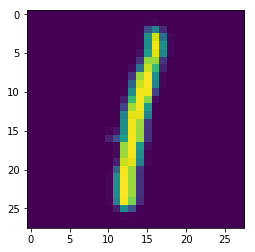

ground truth label:  I
network prediction:  1


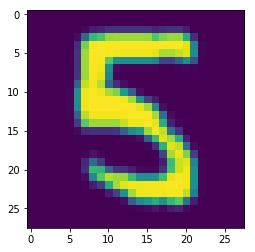

0.00323816783869
2368.28414797


In [11]:
# hessian vector product w.r.t. test image

params = model.logits.parameters

img_test, lb_test = test_set.__getitem__(1)
show_image_from_data(img_test)

print('ground truth label: ', anno_dict['classes'][str(np.argmax(lb_test))])
print('network prediction: ', anno_dict['classes'][str(np.argmax(model.logits.eval({model.X:img_test})))])

v_test = model.loss.grad({model.X:img_test, model.y:lb_test}, wrt=params)

# HVP(y,x,v)
img, lb = train_set.__getitem__(1)
img.shape
show_image_from_data(img)

v_train = model.loss.grad({model.X:img, model.y:lb}, wrt=params)

hvp = HVP(model.loss, {model.X:img, model.y:lb}, v_test)
#model.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')

print(grad_inner_product(hvp, v_test))
print(grad_inner_product(v_test,v_test))

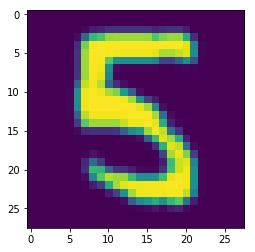

Recursion depth: 0, norm: 48.66894139873618, time: 5.391250371932983 

Recursion depth: 1, norm: 48.5362243354447, time: 5.441539287567139 



-3.0618622361583979e-10

In [19]:
img, lb = train_set.__getitem__(1)
show_image_from_data(img)

v_train = model.loss.grad({model.X:img, model.y:lb}, wrt=params)

model.logits.restore('/Data/checkpts/noisy/model_fold_1_trainval_ratio_1.0.dnn')
model.loss.eval({model.X: img, model.y:lb})

ihvp = IHVP(model, model.loss, v_test, train_set)
grad_inner_product(ihvp[0], v_train)/1000 # loss difference = -1/num_sample * influence function

IHVP를 구하면 발산함!

아마 복잡한 network 때문일 수도 있음.

따라서 단순한 closed-form이 있는 toy example을 만들고, 이에 대해서 해볼 것.
(우선 잘 돌아가는지 확인하기 위해서)

그리고 epoch 단위는 너무 큰 거일 수도 있음.
따라서 step 단위로 바꿀 수 있게도 생각해볼 것

step마다 얼마나 근접하는지도 check

SE가 잘 동작하는데 복잡한 network 상황이기 때문에 안 되는 거라면 

- convex relaxation of network (refer ICML)
- frozen network (feature layer froze)
- simple network (데이터가 얼마나 어려운지를(soft-label) 보는 것이기 때문에 굳이 현 네트워크일 필요는 없음. 따라서 정말 간단한 network를 만들고 학습하여 $\hat{\theta}$을 얻은 후 이를 가지고 IF를 구함.

In [139]:
# toy example for IHVP: 1D example
class SimpleNet(object):
    def __init__(self):
        self.X = C.input_variable(shape=(1,))
        self.h = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.X)
        self.pred = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.h)
        self.y = C.input_variable(shape=(1,))
        #self.loss = C.reduce_l2(self.pred-self.y)
        self.loss = -C.squared_error(self.pred, self.y)
        
class SimpleDataset(object):
    def __init__(self, images, labels):
        self._images, self._labels = images, labels
    
    def __getitem__(self, index):
        X = self._images[index]
        y = self._labels[index]
        
        return X, y
    
    def __len__(self):
        return len(self._images)
    
def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-5
    
    assert type(x)==dict, "Input of HVP is wrong. This should be dictionary"
     
    w = y.parameters
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=params)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=params)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp
    
# stochastic estimation
def IHVP(model, y, v, data_set, verbose=False): # data, network, etc. as we did in GradCAM
    # Calculate inverse hessian vector product over the training set
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    
    # hyperparameters (hp_d)
    recursion_depth = 5
    scale = 1
    damping = 0.0 # paper ref:0.01
    batch_size = 1
    num_samples = 1 # the number of samples(:stochatic estimation of IF) to be averaged
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    inv_hvps = []
    
    params = y.parameters
    
    for i in range(num_samples):
        # obtain num_samples inverse hvps
        cur_estimate = v
        
        for depth in range(recursion_depth):
            # epoch-scale recursion depth
            t1 = time.time()
            for img, lb in dataloader:
                img = img.numpy(); lb = lb.numpy()
                x_feed = {model.X: img, model.y:lb}
                hvp = HVP(y,x_feed,cur_estimate)
                # cur_estimate = v + (1-damping)*cur_estimate + 1/scale*(hvp/batch_size)
                cur_estimate = {ks: v[ks] + (1-damping)*cur_estimate[ks] - (1/scale)*hvp[ks]/batch_size for ks in cur_estimate.keys()}
                #break
                if verbose:
                    print('#w: \n', list(map(lambda x: x.value, params)), '\n#hvp: \n', hvp, '\n#ihvp: \n', cur_estimate)
            print("Recursion depth: {}, norm: {}, time: {} \n".format(depth, np.sqrt(grad_inner_product(cur_estimate,cur_estimate)),time.time()-t1))
        
        inv_hvp = {ks: (1/scale)*cur_estimate[ks] for ks in cur_estimate.keys()}
        inv_hvps.append(inv_hvp)
    
    return inv_hvps
    
    # average among samples
    #ihvp = average(inv_hvps)
    #return ihvp
        
net = SimpleNet()

params = net.pred.parameters

x_feed = {net.X:np.array([[2.]],dtype=np.float32), net.y:np.array([[1.]],dtype=np.float32)}
v_feed = {p: np.ones_like(p.value) for p in params}

print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))

print('hvp', HVP(net.loss, x_feed, v_feed))

params[0].value= np.array([[1.]],dtype=np.float32) # optimal weight w.r.t training points
params[1].value= np.array([[1.]],dtype=np.float32) # optimal weight w.r.t training points

print('w1* = \n', params[0].value, '\nw2* = \n', params[1].value)
print('w^*:', (params[0].value, params[1].value), 'loss:', net.loss.eval(x_feed))

images = np.array([[2.],[2.]], dtype=np.float32)
labels = np.array([[1.5],[.5]], dtype=np.float32)
train_set = SimpleDataset(images, labels)

print('\n###### ihvp start ######\n')
ihvp = IHVP(net, net.loss, v_feed, train_set, verbose=True)

print(ihvp)

w1 = 
 [[-0.60081786]] 
w2 = 
 [[ 0.65675038]] 
loss = 
 [-3.20114636]
hvp {Parameter('W', [], [1 x 1]): array([[ 6.89029694]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 7.43865967]], dtype=float32)}
w1* = 
 [[ 1.]] 
w2* = 
 [[ 1.]]
w^*: (array([[ 1.]], dtype=float32), array([[ 1.]], dtype=float32)) loss: [-1.]

###### ihvp start ######

#w: 
 [array([[ 1.]], dtype=float32), array([[ 1.]], dtype=float32)] 
#hvp: 
 {Parameter('W', [], [1 x 1]): array([[-18.02444458]], dtype=float32), Parameter('W', [], [1 x 1]): array([[-18.02444458]], dtype=float32)} 
#ihvp: 
 {Parameter('W', [], [1 x 1]): array([[ 20.02444458]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 20.02444458]], dtype=float32)}
#w: 
 [array([[ 1.]], dtype=float32), array([[ 1.]], dtype=float32)] 
#hvp: 
 {Parameter('W', [], [1 x 1]): array([[-440.50216675]], dtype=float32), Parameter('W', [], [1 x 1]): array([[-440.50216675]], dtype=float32)} 
#ihvp: 
 {Parameter('W', [], [1 x 1]): array([[ 461.52661133]]

/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in add


애초에 stochastic estimation을 썼을 경우 잘 안되는 example.
hvp가 아무리 잘 되어도 발산함.

strictly convex

$
L(w) = -\sum{(y_i - w_1 w_2 x_i)^2} \\
\text{Assume: single data point, (2,1)} \\
L(w) = -(1-2 w_1 w_2)^2 \\
H = -\left[ {\begin{array}{cc}
   8w_2^2  & 16w_1w_2-4 \\
   16w_1w_2-4 & 8w_1^2 \\
  \end{array} } \right] \\
H^{-1} = -\frac{1}{64w_1^2w_2^2-(16w_1w_2-4)^2}
\left[ {\begin{array}{cc}
   8w_1^2  & -16w_1w_2-4 \\
   -16w_1w_2-4 & 8w_2^2 \\
  \end{array} } \right] \\
\text{Assume: (w_1,w_2)=(1,1)} \\
H = -\left[ {\begin{array}{cc}
   8  & 12 \\
   12 & 8  \\
  \end{array} } \right] \\
H^{-1} = -\frac{1}{20} 
\left[ {\begin{array}{cc}
   2  & -3 \\
   -3 & 2  \\
  \end{array} } \right] \\
\text{Assume: v=[1.,1.]} \\
H^{-1}v = (0.05, 0.05) \\
$

하지만 stochastic estimation으로 생각해보면, initial point는 (1,1)에서 hvp를 구하면 -(20, 20).
현재 cur_estimate은 약 +(20,20)이 된다.
이를 가지고 다시 hvp를 구하면 약 +(400, 400) 정도가 된다.
이를 계속 반복하게 되면 발산하게 된다.

따라서 이는 hvp에서 오차 때문에 발생한 문제가 아니라 stochastic estimation 자체의 불안정성 때문이라고 볼 수 있다.
(참고: tensorflow의 tf.gradients를 사용해서 hvp를 구현할 경우, 오차가 거의 없는 상태로 hvp를 얻어낼 수 있다.)

이후 conjugate gradient를 구현해서 실험해 볼 것이다.

### CONVEX 문제가 아니었음. 해당 H의 eigen value를 구하면 20, -4가 나옴!

w를 잘 잡으면 hessian을 convex하게 만들 수 있음. 
즉 특정 w에 대해서는 convex한 hessian을 얻을 수 있지만, 또 특정 w에 대해서는 convex하지 않음.
만약 w를 고정해서 hessian matrix를 convex하게 잡고 난 다음엔 L로부터 inverse hessian vector product를 하는게 가능한가?

HVP를 할 때 w를 $w+r*v$ 등으로 비틀어서 보게 되는데, 이런 경우 convex 하지 않으면 문제가 발생할 수도?
는 아님!. 저건 그냥 미분 정의에서 나오는 거라서 convex 안해도 됨.

gradient가 w가 1개일 경우 dictionary가 아니라 array가 됨. (일관성 무엇?)

또 사실 w가 1개일 경우 hessian이 matrix가 아니기 때문에 너무 trivial한 경우라고 생각됨.

### answer = 1/12 [[1.], [1.]]

2차원에서 수렴하는거 step마다 찍기!

## 추가해볼 것

- Hessian 보고 eigen value 구해서 positive definite인지 check.
- 아니라면 warning message 추가하기. (이거 때문에 잘 못 되는건지 확인하기 위해서)

## Conjugate gradient

In [171]:
def grad_inner_product(grad1, grad2):
    # inner product for dictionary-format gradients (output scalar value)
    
    val = 0
    
    for ks in grad1.keys():
        #C.inner(grad1[ks], grad2[ks])
        val += np.sum(np.multiply(grad1[ks],grad2[ks]))
        #val += np.dot(grad1[ks], grad2[ks])
        
    return val

def weight_update(w, v, r):
    # w: weights of neural network (tuple)
    # v: value for delta w (dictionary, e.g., gradient value)
    # r: hyperparameter for a gradient (scalar)

    for p in w:
        p.value += r * v[p]
        
def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-5
    
    assert type(x)==dict, "Input of HVP is wrong. This should be dictionary"
     
    w = y.parameters
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=params)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=params)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp

def HVP_minibatch_val(model, y, v, data_set):
    # Calculate Hessian vector product w.r.t whole dataset
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    
    # hyperparameters
    damping = 0.0 # convexity term; paper ref:0.01
    batch_size = 1
    
    hvp_batch = {ks: [] for ks in v.keys()}
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    for img, lb in dataloader:
        img = img.numpy(); lb = lb.numpy()
        x_feed = {model.X: img, model.y:lb}
        hvp = HVP(y,x_feed,v)
        # add hvp value
        [hvp_batch[ks].append(hvp[ks]/img.shape[0]) for ks in hvp.keys()]
        
    hvp_mean = {ks: np.mean(hvp_batch[ks], axis=0) + damping*v[ks] for ks in hvp_batch.keys()}
    
    return hvp_mean

from scipy.optimize import fmin_ncg

# 정리정리!! 함수 인풋도 정리!
# x: solution vector for conjugate gradient, whose shape is same as flattened gradient. NOT feed dict value

def dic2vec(dic):
    # convert a dictionary with matrix values to a 1D vector
    # e.g. gradient of network -> 1D vector
    vec = np.concatenate([val.reshape(-1) for val in dic.values()])
    
    return vec

# Do we need this?
#def vec2dic(vec, fmt):
    # convert a 1D vector to a dictionary of format fmt
    # fmt = {key: val.shape for (key,val) in dict}

def get_fmin_loss_fn(model, y, data_set, v):
    
    def get_fmin_loss(x):
        hvp_val = HVP_minibatch_val(model, y, x, data_set)
        hvp_flat = dic2vec(hvp_val)
        
        return 0.5 * grad_inner_product(hvp_flat, x) - grad_inner_product(v, x)
    
    return get_fmin_loss

def get_fmin_grad_fn(model, y, data_set, v):
    
    def get_fmin_grad(x):
        hvp_val = HVP_minibatch_val(model, y, x, data_set)
        hvp_flat = dic2vec(hvp_val)
        v_flat = dic2vec(v)
        
        return hvp_flat - v_flat
    
    return get_fmin_grad

def get_fmin_hvp(model, y, x, data_set):
    hvp_val = HVP_minibatch_val(model, y, x, data_set)
    hvp_flat = dic2vec(hvp_val)
    
    return hvp_flat

def get_inverse_hvp_cg(model, y, data_set, v):
    # return x, which is the solution whose value is H^-1 v
    
    fmin_loss_fn = get_fmin_loss_fn(model, y, data_set, v)
    fmin_grad_fn = get_fmin_grad_fn(model, y, data_set, v)
    
    fmin_results = fmin_ncg(\
                           f = fmin_loss_fn,\
                           x0 = dic2vec(v),\
                           fprime = fmin_grad_fn,
                           fhess_p = get_fmin_hvp,\
                           avextol = 1e-8,\
                           maxiter = 1e2)
    
    return fmin_results
    #return vec2dic(fmin_results)

In [172]:
# toy example for IHVP: 1D example
class SimpleNet(object):
    def __init__(self):
        self.X = C.input_variable(shape=(1,))
        self.h = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.X)
        self.pred = C.layers.Dense(1, activation=None, init=C.uniform(1), bias=False)(self.h)
        self.y = C.input_variable(shape=(1,))
        #self.loss = C.reduce_l2(self.pred-self.y)
        self.loss = -C.squared_error(self.pred, self.y)
        
class SimpleDataset(object):
    def __init__(self, images, labels):
        self._images, self._labels = images, labels
    
    def __getitem__(self, index):
        X = self._images[index]
        y = self._labels[index]
        
        return X, y
    
    def __len__(self):
        return len(self._images)
    

      
net = SimpleNet()

params = net.pred.parameters

x_feed = {net.X:np.array([[2.]],dtype=np.float32), net.y:np.array([[1.]],dtype=np.float32)}
v_feed = {p: np.ones_like(p.value) for p in params}

print('w1 = \n', params[0].value, '\nw2 = \n', params[1].value, '\nloss = \n', net.loss.eval(x_feed))

print('hvp', HVP(net.loss, x_feed, v_feed))

images = np.asarray([[2.],[2.]], dtype=np.float32)
labels = np.asarray([[1.],[1.]], dtype=np.float32)
train_set = SimpleDataset(images,labels)

print('hvp_batch', HVP_minibatch_val(net, net.loss, v_feed, train_set))

print('inverse hvp', get_inverse_hvp_cg(net, net.loss, train_set, v_feed))

w1 = 
 [[ 0.23605482]] 
w2 = 
 [[-0.94090229]] 
loss = 
 [-2.08573985]
hvp {Parameter('W', [], [1 x 1]): array([[ 0.47683716]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 7.10487366]], dtype=float32)}
hvp_batch {Parameter('W', [], [1 x 1]): array([[ 0.47683716]], dtype=float32), Parameter('W', [], [1 x 1]): array([[ 7.10487366]], dtype=float32)}


AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [ ]:
def HVP(y, x, v):
    # Calculate Hessian vector product 
    # y: scalar function to be differentiated (function, e.g. cross entropy loss)
    # x: feed_dict value for the network (dictionary, e.g. {model.X: image_batch, model.y: label_batch})
    # v: vector to be producted (by Hessian) (numeric dictionary, e.g., g(z_test))
    ## w: variables to differentiate (numeric, e.g. neural network weight)
    
    # hyperparameter r
    r = 1e-2
    
    assert type(x)==dict, "Input of HVP is wrong. this should be dictionary"
     
    w = y.parameters
    
    # gradient for plus
    weight_update(w, v, +r)
    g_plus = y.grad(x, wrt=params)
  
    # gradient for minus
    weight_update(w, v, -2*r)
    g_minus = y.grad(x, wrt=params)
    
    # weight reconstruction
    weight_update(w, v, +r)
    
    hvp = {ks: (g_plus[ks] - g_minus[ks])/(2*r) for ks in g_plus.keys()}
       
    return hvp

# stochastic estimation
def IHVP(model, y, v, data_set, verbose=False): # data, network, etc. as we did in GradCAM
    # Calculate inverse hessian vector product over the training set
    # model: neural network model (e.g. model)
    # y: scalar function output of the neural network (e.g. model.loss)
    # v: vector to be producted by inverse hessian (i.e.H^-1 v) (e.g. v_test)
    # data_set: training set to be summed in Hessian
    
    # hyperparameters (hp_d)
    recursion_depth = 5
    scale = 1
    damping = 0.0 # paper ref:0.01
    batch_size = 1
    num_samples = 1 # the number of samples(:stochatic estimation of IF) to be averaged
    
    dataloader = DataLoader(data_set, batch_size, shuffle=True, num_workers=6)
    
    inv_hvps = []
    
    params = y.parameters
    
    for i in range(num_samples):
        # obtain num_samples inverse hvps
        cur_estimate = v
        
        for depth in range(recursion_depth):
            # epoch-scale recursion depth
            t1 = time.time()
            for img, lb in dataloader:
                img = img.numpy(); lb = lb.numpy()
                x_feed = {model.X: img, model.y:lb}
                hvp = HVP(y,x_feed,cur_estimate)
                # cur_estimate = v + (1-damping)*cur_estimate + 1/scale*(hvp/batch_size)
                cur_estimate = {ks: v[ks] + (1-damping)*cur_estimate[ks] - (1/scale)*hvp[ks]/batch_size for ks in cur_estimate.keys()}
                #break
                if verbose:
                    print('#w: \n', list(map(lambda x: x.value, params)), '\n#hvp: \n', hvp, '\n#ihvp: \n', cur_estimate)
            print("Recursion depth: {}, norm: {}, time: {} \n".format(depth, np.sqrt(grad_inner_product(cur_estimate,cur_estimate)),time.time()-t1))
        
        inv_hvp = {ks: (1/scale)*cur_estimate[ks] for ks in cur_estimate.keys()}
        inv_hvps.append(inv_hvp)
    
    return inv_hvps

In [13]:
gd1 = y.grad({x:np.array([[1.]])}, wrt=y.parameters)
gd2 = y.grad({x:np.array([[1.],[1.]])}, wrt=y.parameters)
print(gd1,gd2)

{Parameter('W', [], [1 x 1]): array([[-0.68041325]], dtype=float32), Parameter('W', [], [1 x 1]): array([[-0.7322467]], dtype=float32)} {Parameter('W', [], [1 x 1]): array([[-1.36082649]], dtype=float32), Parameter('W', [], [1 x 1]): array([[-1.46449339]], dtype=float32)}


/home/hwehee/anaconda3/envs/cntk/lib/python3.5/site-packages/cntk/core.py:361: UserWarning: your data is of type "float64", but your input variable (uid "Input3") expects "<class 'numpy.float32'>". Please convert your data beforehand to speed up training.
  (sample.dtype, var.uid, str(var.dtype)))


remark) gradient with minibatch whose size is greater than 1
여러 sample에 대해서 gradient을 구하는 경우 average 대신 summation된 값을 내보냄.
따라서 hvp를 sample 수에 대해서 normalize해줘야 함.